In [1]:
import time
import sys
import os
from collections import OrderedDict
from importlib import reload
from pprint import pprint

import h5py
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
import qcodes
qc = qcodes

In [3]:
from stationq.mplplots.init_nb_plotting import *
from stationq.mplplots import plots as mplplots
from stationq.mplplots import tools as mpltools

In [12]:
# from quantum_capacitance import rf; reload(rf)
# from quantum_capacitance.rf import AlazarMeasurementExt, AWGMeasurement, AWG2DRamp

# Basic configuration

In [5]:
%run init.py

2018-01-30 14:40:32,983 : measurement : INFO : Logger set up!


Initialized IVVI-rack in 0.11s
Connected to: Keysight Technologies 34465A (serial:MY57503596, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110525, firmware:3.1.19.15-3.50.124.67) in 0.03s


C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:209: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '


Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110524, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: TEKTRONIX AWG5014C (serial:B051388, firmware:SCPI:99.0 FW:4.6.0.7) in 0.06s
Connected to: Rigol Technologies DG4062 (serial:DG4E163251554, firmware:00.01.09) in 0.04s


C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:514: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:526: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


In [6]:
from stationq.data.data_storage import Data, GridData
Data.export_spyview = True
GridData.export_spyview = True

# Definitions

# Experiments

## DC IV traces

In [11]:
station.key1.volt()

0.006128877

In [10]:
station.ivvi.dac1(0)

In [42]:
from stationq.experiment.measurement import BaseMeasurement

class IVCurve(BaseMeasurement):
    
    start = -150.
    stop = + 150
    pts = 1001
    
    def measure(self):
        self.station.key1.NPLC(1)
        vals = []
        bias = np.linspace(self.start, self.stop, self.pts)
        for v in bias:
            self.station.ivvi.dac1(v)
            time.sleep(0.01)
            amp = self.station.key1.volt()
            
            self.data.add(
            OrderedDict({
                'Bias' : {'value' : v * 1e-6, "unit": 'V', "independent_parameter": True},
                'Current' : {'value' : amp * 1e-7, "unit": 'A'},
                })
            )
        

In [43]:
T = 100
t0 = time.time()
delay = 5

m = IVCurve(station, namespace)
m.run()

2018-01-30 16:34:21,982 : measurement : INFO : Ready to measure, file location: d:\data\2018-01\2018-01-30\2018-01-30_IVCurve-#0005...
2018-01-30 16:36:42,074 : measurement : INFO : Measurement finished, cleaning up...
2018-01-30 16:36:42,154 : measurement : INFO : All done!


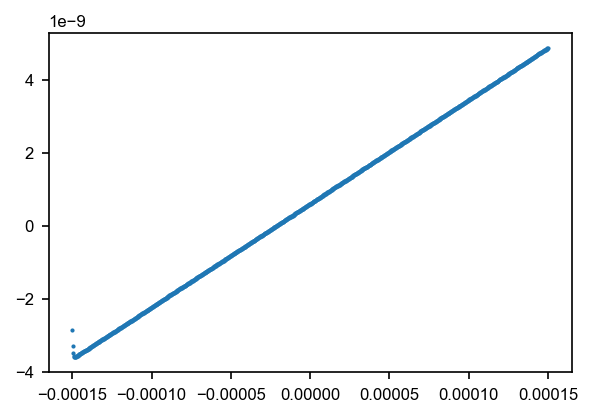

In [44]:
bias = m.data['Current']['Bias [V]'].reshape(-1)
amp = m.data['Current']['Current [A]'].reshape(-1)

fig, ax = plt.subplots(1,1)
ax.plot(bias, amp, 'o', ms=1)
# ax.set_yscale('log')

In [41]:
300e-6 / 8e-9

37499.99999999999

### Stability Diagram

In [ ]:
start = 0
stop = 2000
pts = 51
navg = 1


RF_frq = 538.2e6
RF_pwr = -65
t_int = 80e-6

station.fg.ch1_frequency(50)

# RF_frq = 1.040e9
# RF_frq = 1.398e9
# RF_pwr = -35
# t_int = 1.2e-3
 
# LO_pwr = 10 # use for IQ mixer
LO_pwr = 22 # use for interferometer

station.RF.frequency(RF_frq)
station.RF.power(RF_pwr)
station.LO.power(LO_pwr)

# make sure we trigger externally
namespace.ats_settings['trigger_source1'] = 'EXTERNAL'

# set sampling rate of the alazar
namespace.ats_settings['sample_rate'] = int(1e8)

# awg as low sampling as possible
namespace.awg_settings['sampling_rate'] = int(1e7)

# limit awg output
namespace.awg_settings['channel_2']['analog_amplitude'] = 0.2

In [ ]:
t1 = -855
t2 = -640
t3 = -875
station.ivvi.dac4(t1) # T1
station.ivvi.dac5(t2) # T2
station.ivvi.dac6(t3) # T3

t1, t2, t3 = int(station.ivvi.dac4()), int(station.ivvi.dac5()), int(station.ivvi.dac6())
t1, t2, t3

In [ ]:
# for RF_pwr in np.array([-50., -45., -40., -35., -30., -25., -20., -15., ]):
# for t2 in (-700.0 - np.arange(5) * 2.0):
info = None
# info = f'pwr={RF_pwr}'
# info = f'IF={IF}'
info = f't1={int(t1)}_t2={int(t2)}_t3={int(t3)}'

# create measurement class and run
m = AWGGateSweep(station, namespace, info_string=info)
m.awg_chan(2)
m.ramp_pts(200)
m.max_val(0.1)
m.ramp_down_len(1e-3)
m.ats_int_time(t_int)
m.navgs(navg)
m.IF(20e6)

m.sweep = [
    (m.station.ivvi.dac7, np.linspace(start, stop, pts))
]
m.run()

for zname in ['delta_phase', 'chanB_abs']:
    z, [(xname, x), (yname, y)] = m.data[zname]
    fig, ax = plt.subplots(1,1)
    im = mplplots.ppcolormesh(ax, x, y, z.T)
    cb = fig.colorbar(im)
    cb.set_label(zname)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_title(m.data.filepath, size='x-small')
    fig.savefig(m.metadata_prefix + f"_{zname}.png", dpi=300, transparent=False)

In [ ]:
station.ivvi.set_dacs_zero()

In [ ]:
ivvi.set_dacs_zero()

In [ ]:
80 * 90 * 2 * 80 * 100 * 2 * 2 * 1e-6